This notebook is supposed to drive oscillators with moving random dots so that they only reach certain phases if dot motion is in the preferred direction around the preferred speed. Gabor-like features are supposed to drive the oscillators. The Gabors are weighted sums of difference-of-gaussian units that emit short bursts as they cross a threshold. 

It is finicky to get reasonable Gabor approximations from the DOG bursts. It works OK if only a few PCs are used to find decoders. 

Even so, the oscillators are quite noisy. There is a "if True:" block a few cells down that replaces the Gabor approximation with something simpler, which seems to work slightly better.  

I tried various transforms from Gabor to oscillator (with the goal of only letting the state enter a certain area if the direction and speed matched). This kind of works. 

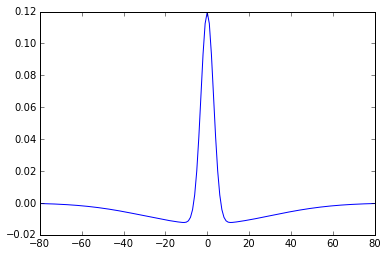

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def make_DOG(inner_sigma, x): 
    """ Make a 1D difference-of-Gaussians kernel. """
    outer_sigma = inner_sigma*10
    inner_gaussian = 1./np.sqrt(2*np.pi)/inner_sigma * np.exp(-x**2/2./inner_sigma**2)
    outer_gaussian = 1./np.sqrt(2*np.pi)/outer_sigma * np.exp(-x**2/2./outer_sigma**2)
    return inner_gaussian - outer_gaussian

x = np.arange(-80, 81)
DOG = make_DOG(3, x)
plt.plot(x, DOG)
plt.show()

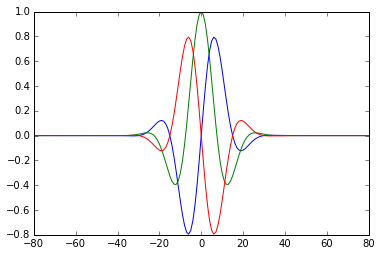

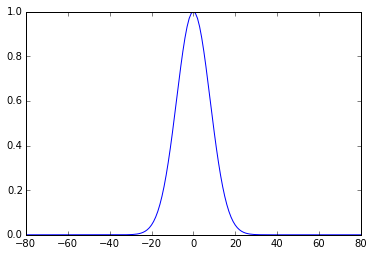

(161, 3)


In [2]:
def make_gabor(x, frequency, phase, sigma): 
    """ Make a Gabor kernel. """
    return np.cos(frequency*x + phase) * np.exp(-x**2/2./sigma**2)

gabor_frequency = 2*np.pi/30
gaborx = np.zeros((len(x), 3))
gaborx[:,0] = make_gabor(x, gabor_frequency, -np.pi/2, 10)
gaborx[:,1] = make_gabor(x, gabor_frequency, 0, 10)
gaborx[:,2] = make_gabor(x, gabor_frequency, np.pi/2, 10)

plt.plot(x, gaborx)
plt.show()

gabory = np.exp(-x**2/2./8**2)
plt.plot(x, gabory)
plt.show()

print gaborx.shape

In [3]:
dog_matrix = np.zeros((x.shape[0], x.shape[0]))
offsets = x
dog_padded = np.concatenate((np.zeros(80), DOG, np.zeros(80)))
for i in range(len(x)): 
    dog_matrix[i,:] = dog_padded[i:i+len(x)]

#plt.imshow(dog_matrix)
#plt.show()

#val, vec = np.linalg.eig(dog_matrix)

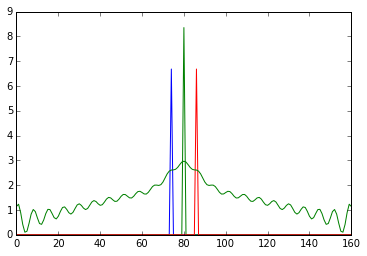

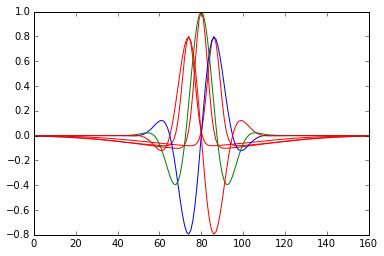

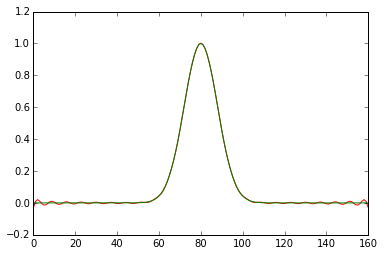

In [4]:
gamma = np.dot(dog_matrix, dog_matrix.T)
inv_gamma = np.linalg.pinv(gamma, 1e-1) #with tighter tolerance, Gabor side-lobes disappear if LGN is thresholded
weightsx = np.dot(inv_gamma, np.dot(dog_matrix, gaborx))
inv_gamma = np.linalg.pinv(gamma, 1e-3)  
weightsy = np.dot(inv_gamma, np.dot(dog_matrix, gabory))

if True: 
    # a simple manual approximation  
    weightsx = np.zeros_like(weightsx)
    weightsx[74,0] = .8/np.max(DOG)
    weightsx[80,1] = 1/np.max(DOG)
    weightsx[86,2] = .8/np.max(DOG)

plt.plot(weightsx)
plt.plot(weightsy, 'g')
plt.show()

approxx = np.dot(dog_matrix.T, weightsx)
plt.plot(approxx, 'r')
plt.plot(gaborx)
plt.show()

approxy = np.dot(dog_matrix.T, weightsy)
plt.plot(approxy, 'r')
plt.plot(gabory, 'g')
plt.show()

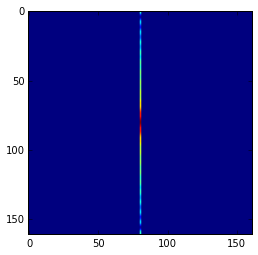

(161, 161, 3)


In [5]:
weightsxy = np.zeros((len(weightsy), len(weightsy), 3))
for i in range(3):
    weightsxy[:,:,i] = np.outer(weightsy, weightsx[:,i])
    
plt.imshow(weightsxy[:,:,1])
plt.show()
print weightsxy.shape

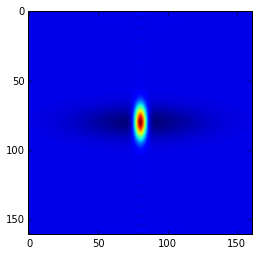

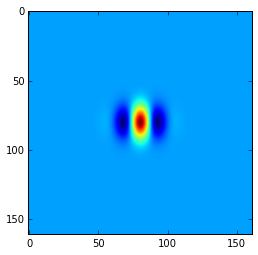

In [6]:
#plot comparison of ideal vs. reconstructed gabor
from scipy import ndimage as nd

dd1 = nd.filters.convolve1d(weightsxy[:,:,1], DOG, axis=0, mode='constant')    
dd2 = nd.filters.convolve1d(dd1, DOG, axis=1, mode='constant')

plt.imshow(dd2)
plt.show()

gaborxy = np.outer(gabory, gaborx[:,1])
plt.imshow(gaborxy)
plt.show()

In [7]:
# see what the receptive field looks like (hopefully not too different) ... 
dot_start = -80
dot_step = 4
dot_ind = range(dot_start, -dot_start+1, dot_step) #just probe central region (expect RF at centre)
dotx = np.tile(dot_ind, (len(dot_ind), 1))
doty = dotx.transpose()
dotx_list = np.ndarray.flatten(dotx)
doty_list = np.ndarray.flatten(doty)

#img_ind = range(-200, 200, 1)
imgx = np.tile(x, (len(x), 1))
imgy = imgx.transpose()

In [8]:
#this cell takes ~1/2 minute
threshold = 10
V1_RF = np.zeros_like(dotx)

for i in range(len(dotx_list)):
    #print i

    img = np.zeros_like(imgx)
    radius = 2
    mask = (imgx-dotx_list[i])**2+(imgy-doty_list[i])**2 <= radius**2
    img[mask] = 255

    dd1 = nd.filters.convolve1d(img, DOG, axis=0, mode='constant')    
    dd2 = nd.filters.convolve1d(dd1, DOG, axis=1, mode='constant')
    LGN = np.zeros_like(dd2)
    LGN[dd2 > threshold] = 1
    #LGN = dd2
    V1 = np.dot(np.reshape(LGN, (-1)), np.reshape(weightsxy[:,:,1], (-1)))
    V1_RF[(doty_list[i]-dot_start)/dot_step, (dotx_list[i]-dot_start)/dot_step] = V1

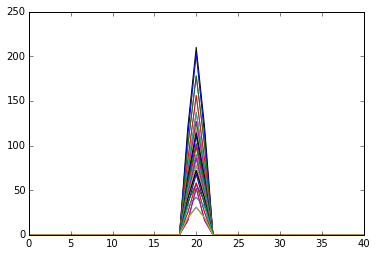

In [9]:
plt.plot(V1_RF.T)
plt.show()

In [10]:
#this is a relatively sparse stimulus (15 dots on screen at a time)  
import cPickle as pickle
dot_images = pickle.load(open("dot-images-15-short.p", "rb" ))
n_frames = dot_images.shape[2]

In [11]:
sample_hold_ratio = 10

# just dealing with image centre for now ... 
im_ind = min(x) + 200 + range(len(x))

weights = np.zeros((len(weightsy)**2, 3))
for i in range(3):
    weights[:,i] = np.reshape(weightsxy[:,:,i], (-1))

dd_prev = np.zeros((len(im_ind), len(im_ind)))
LGN = np.zeros((len(im_ind), len(im_ind), n_frames*sample_hold_ratio))
gabor = np.zeros((weightsxy.shape[2], n_frames*sample_hold_ratio))

for frame_num in range(n_frames): 
    dot_image = dot_images[:,:,frame_num]
    dd1 = nd.filters.convolve1d(dot_image.take(im_ind, axis=0).take(im_ind, axis=1), DOG, axis=0, mode='constant')  
    dd2 = nd.filters.convolve1d(dd1, DOG, axis=1, mode='constant')

    for step_num in range(sample_hold_ratio): 
        threshold_crossings = np.logical_and(dd2 > dd_prev, dd2 > threshold)
        t_ind = frame_num*sample_hold_ratio+step_num

        LGN[threshold_crossings,t_ind] = 1
        if t_ind < n_frames*sample_hold_ratio-1: #Aziz uses a 2-ms burst at each threshold crossing
            LGN[threshold_crossings,t_ind+1] = 1
        
        LGN_ind = LGN[:,:,t_ind]
        gabor[:,t_ind] = np.dot(np.reshape(LGN_ind, (-1)), weights)
            
        dd_prev = dd2

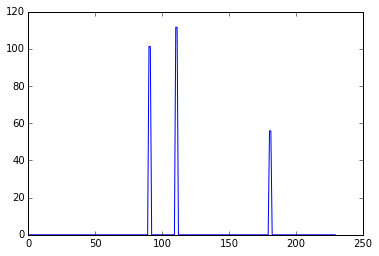

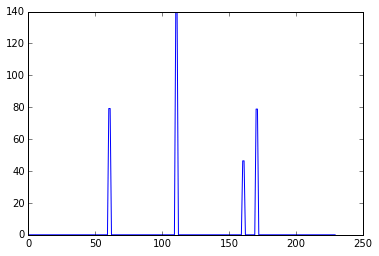

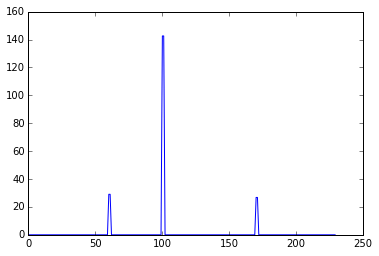

In [12]:
plt.plot(gabor[0,:])
plt.show()
plt.plot(gabor[1,:])
plt.show()
plt.plot(gabor[2,:])
plt.show()

In [13]:
# This cell copied from fpga-motion notebook ... 

import nengo 

def gabor_out(t): 
    dt = .001
    step_num = np.round(t/dt)
    return np.maximum(0, gabor[:,step_num])

width = 1 #number of v1 populations across
height = 1 #number of v1 populations down
n_dirs = 2 #Number of V1 oscillator directions
n_speeds = 3 #Number of V1 oscillator speeds
tcs = np.array([40,100,160])*0.001 #Time constants corresponding to the 20... ms half periods in the thesis for speeds

#This function builds subnets of n_dir x n_speeds populations that need to be connected to the
#input of aligned LGN elements in a direction to give them the desired preferred direction
def V1_subpopulation():
    #Damped oscillator parameters
    freqs = (2*np.pi)/tcs  #frequencies, Rad/s
    #damp = -1.*freqs #corresponding damping values, 2 is critical damping
    damp = -.75*freqs #corresponding damping values, 2 is critical damping
    V1_tau = 0.02
    V1sub=[]
    V1sub_probe=[]

    for j in range(n_dirs):
        cur_pop = []
        cur_probe = []
        for i in range(n_speeds):
            cur_pop.append(nengo.Ensemble(nengo.LIF(200), 
                                dimensions=2))
            #negate the freqs to make it rotate the other direction (opposite motion)
            A = np.array([[damp[i], freqs[i]], [-freqs[i], damp[i]]])
            #print (freqs[ind]/(2*np.pi)), damp[ind]
            nengo.Connection(cur_pop[i], cur_pop[i], transform=(V1_tau*A+np.eye(2)), filter=V1_tau)  #make it an oscillator
            cur_probe.append(nengo.Probe(cur_pop[i],'decoded_output', filter=V1_tau))
        V1sub_probe.append(cur_probe)
        V1sub.append(cur_pop)
    return V1sub, V1sub_probe

ImportError: No module named nengo

In [ ]:
model = nengo.Model('Motion')
v1_input = nengo.Node(output=gabor_out, size_in=0, size_out=gabor.shape[0], label="Gabor")
input_probe = nengo.Probe(v1_input, 'output')
V1, V1_probe = V1_subpopulation()

# populations that code different speeds differ only in oscillator time constant
# populations that code different directions differ in using left or right gabor with centre gabor
for i in range(len(V1[0])): 
    nengo.Connection(v1_input, V1[0][i], transform=[[.2,0,-.2],[0,-.2,0]]) # <-- these numbers are for bumping the state with input at different phases
    
for i in range(len(V1[1])): 
    nengo.Connection(v1_input, V1[1][i], transform=[[-.2,0,.2],[0,-.2,0]])
    
sim = nengo.Simulator(model)
sim.run(.99)

In [ ]:
#Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(3.5, 6))
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(sim.trange(), sim.data(input_probe)[:,i])
    plt.title(str(i))

# plotting one direction over time and state trajectory
plt.figure(figsize=(4*n_speeds, 4*n_dirs))
for j in range(n_dirs):
    for i in range(n_speeds):
        plt.subplot(n_dirs,n_speeds,(j*n_speeds)+i+1)
        plt.plot(sim.trange(), sim.data(V1_probe[j][i]))

plt.figure(figsize=(4*n_speeds, 4*n_dirs))
for j in range(n_dirs):
    for i in range(n_speeds):
        ax = plt.subplot(n_dirs,n_speeds,(j*n_speeds)+i+1)
        plt.plot(sim.data(V1_probe[j][i])[:,0], sim.data(V1_probe[j][i])[:,1])
        ax.set_xlim([-1,1])
        ax.set_ylim([-1,1])
